In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import nltk
import string
import re
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Input, Dense, Dropout, concatenate, Reshape
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

stop = set(stopwords.words("english"))
words = set(nltk.corpus.words.words())

# max_len = 2000

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))


INFO:tensorflow:Initializing the TPU system: grpc://10.23.109.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.23.109.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [4]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("/content/gdrive/MyDrive/data_clean&processed.csv")
df.head(1)


,Unnamed: 0,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,id,launched_at,location,name,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,story,faq,num_faq,comments,n_comments,duration,parent_category,category_name,location_name,month_launched,year_launched,backers_count_log,goal_log,pledged_log,duration_log,n_comments_log,num_faq_bool,avg_fund_per_backer,comments_afinn,blurb_name,faq_comments
0,0,1,With your help we will create this device that...,"{'id': 331, 'name': '3D Printing', 'slug': 'te...",1,ES,2015-08-18 21:01,USD,2016-07-09 20:11,1.212886,15000,1662798399,2016-06-09 20:11,"{""id"":55897673,""name"":""Mexico"",""slug"":""mexico-...",Save water 100% liquid downloads in toilets at...,1.0,"{""id"":2075449,""project_id"":2075449,""state"":""in...",save-water-100-liquid-downloads-in-toilets,https://www.kickstarter.com/discover/categorie...,False,False,0,2016-07-09 20:11,1.13693,"{""web"":{""project"":""https://www.kickstarter.com...",1.13693,domestic,Producto Final\r\nHi! The funds we will used t...,[' '],0,No comments yet.,0.0,30,Technology,3D Printing,Mexico,6,2016,-1.390561,0.689521,-1.915118,-0.012145,-0.710711,0,1.0,-1.0,With your help we will create this device that...,[' ']No comments yet.


In [5]:
le = LabelEncoder()

le.fit(df["parent_category"])
df["parent_category"] = le.transform(df["parent_category"])

le.fit(df["category_name"])
df["category_name"] = le.transform(df["category_name"])

le.fit(df["location_name"])
df["location_name"] = le.transform(df["location_name"])


In [6]:
columns_categorical = ["parent_category","category_name","location_name"]
columns_numeric = ["n_comments","duration","backers_count_log","goal_log","pledged_log",
                   "duration_log","n_comments_log","avg_fund_per_backer"]

In [7]:
def clean_text(text):
  table = str.maketrans("","",string.punctuation)
  text = " ".join(word.lower() for word in nltk.wordpunct_tokenize(text) \
                   if word.lower() in word or not word.isalpha()) 
  text = text.translate(table)
  text = " ".join([word for word in text.split() if len(word)>1])
  return " ".join([word for word in text.split() if word.lower() not in stop])

In [8]:
df['story'] = list(map(
    lambda x : clean_text(x),
    df["story"]
))

In [9]:
def create_corpus(df):
    corpus = []
    for text in df["story"]:
        words = [word for word in word_tokenize(text)]
        corpus.append(words)
    return corpus
corpus = create_corpus(df)

In [10]:
max_len = max([len(x) for x in df["story"]])
num_words = len(corpus)
num_words

985

In [11]:
X = df[columns_categorical + columns_numeric + ["story"]]
y = df["state"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(X_train["story"])

In [14]:
X_train_seq = tokenizer.texts_to_sequences(X_train["story"])
X_train_padded = pad_sequences(
    X_train_seq, maxlen = max_len, truncating = "post", padding = "post"
)

X_test_seq = tokenizer.texts_to_sequences(X_test["story"])
X_test_padded = pad_sequences(
    X_test_seq, maxlen = max_len, truncating = "post", padding = "post"
)

In [15]:
embedding_dict = {}
with open("/content/gdrive/MyDrive/glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],"float32")
        embedding_dict[word] = vectors
f.close()

In [16]:
word_index = tokenizer.word_index

In [17]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words,100))

for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

In [18]:
model_lstm = Sequential()

model_lstm.add(
    Embedding(
    num_words,
    100,
    embeddings_initializer = Constant(embedding_matrix),
        input_length = max_len,
        trainable = False,
    )
)
model_lstm.add(LSTM(100, dropout = 0.2))
model_lstm.add(Dense(1, activation = "sigmoid"))
optimizer_lstm = Adam(learning_rate = 5e-2)

model_lstm.compile(loss = "binary_crossentropy", optimizer = optimizer_lstm, metrics = ["accuracy"])

In [19]:
text_input = Input(
    shape=(None, ), name = "text")

text_features =Embedding(
    num_words,
    100,
    embeddings_initializer =  Constant(embedding_matrix),
    input_length = max_len,
    trainable = False,
    )(text_input)

text_features = LSTM(100)(text_features)



In [20]:
columns_categorical

['parent_category', 'category_name', 'location_name']

In [21]:
pcat_input = Input(
    shape=(None, ), name = "parent category")

cat_input = Input(
    shape=(None, ), name = "category")

loc_input = Input(
    shape=(None, ), name = "location")


embedding_size_pcat = max(df["parent_category"])

embedding_size_cat = max(df["category_name"])

embedding_size_loc = max(df["location_name"])


pcat_features = Embedding(
    embedding_size_pcat + 1 ,
    embedding_size_pcat, 
    input_length = 1)(pcat_input)

cat_features = Embedding(
    embedding_size_cat + 1 ,
    embedding_size_cat, 
    input_length = 1)(cat_input)

loc_features = Embedding(
    embedding_size_loc + 1 ,
    embedding_size_loc, 
    input_length = 1)(loc_input)

pcat_features = Reshape(
    target_shape=(embedding_size_pcat,)
    )(pcat_features)


cat_features = Reshape(
    target_shape=(embedding_size_cat,)
    )(cat_features)


loc_features = Reshape(
    target_shape=(embedding_size_loc,)
    )(loc_features)


In [22]:
numeric_input = Input(
    shape=(8, ), name = "numeric")

numeric_features = Dense(units = len(columns_numeric),
                         activation='relu', name = "hidden_1")(numeric_input)

numeric_features = Dense(units = len(columns_numeric),
                         activation='relu', name = "hidden_2")(numeric_features)


In [23]:
merge_layer = concatenate([text_features, pcat_features, cat_features,loc_features,numeric_features])

predict_layer = Dense(1, name = "status")(merge_layer)

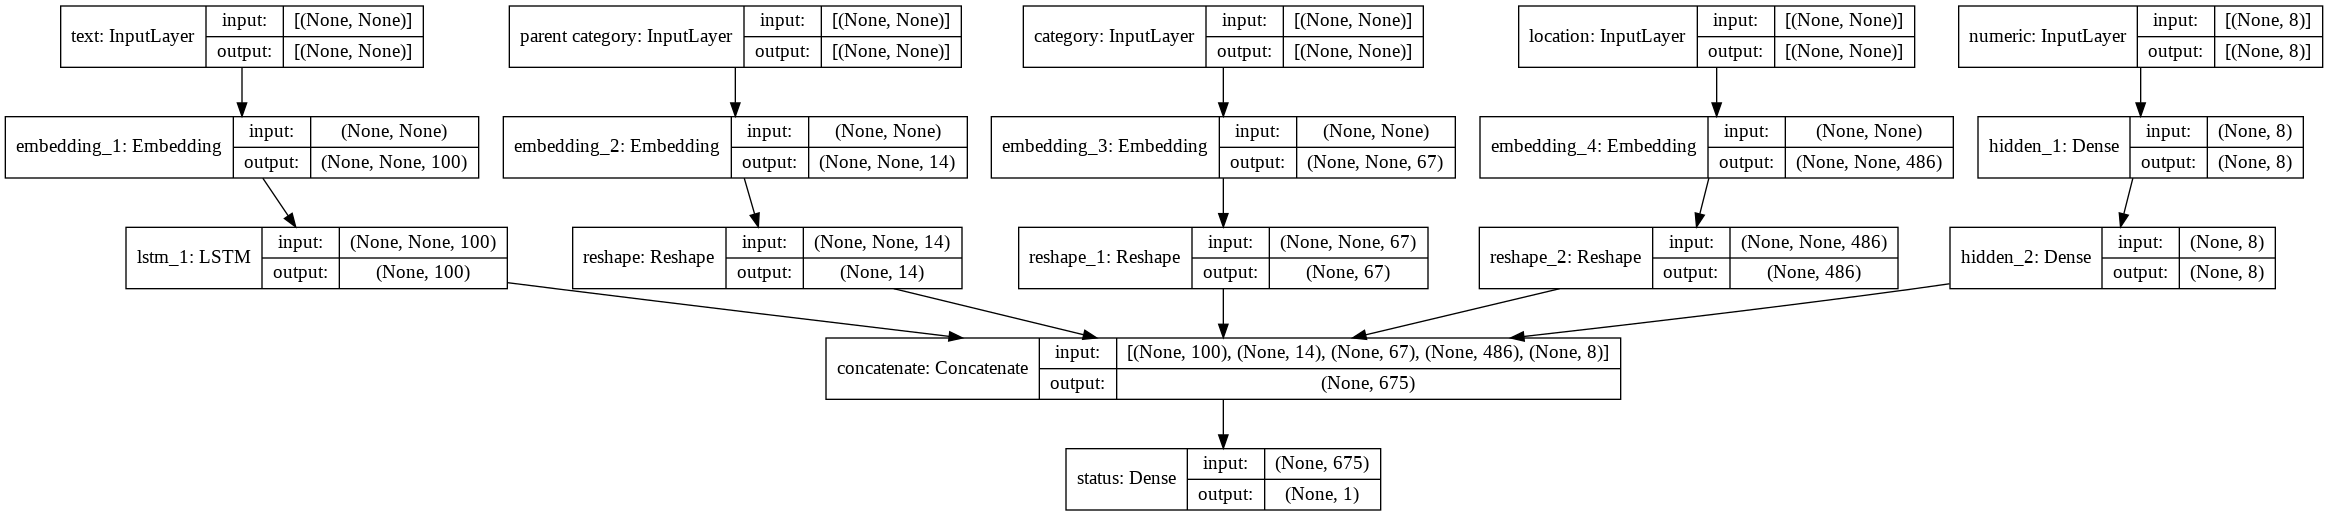

In [24]:
model = tf.keras.Model(
    inputs=[text_input, pcat_input, cat_input,loc_input,numeric_input],
    outputs=[predict_layer],
)

tf.keras.utils.plot_model(model, "model.png", show_shapes=True)


In [37]:
model.compile(
    optimizer=Adam(1e-3),
    loss={
        "status" : tf.keras.losses.BinaryCrossentropy(from_logits=True)
    },
    loss_weights=[1.0],
    metrics=["accuracy"]
)


In [38]:
model.fit(
    {"text" : X_train_padded, 
     "parent category" : X_train["parent_category"],
     "category" : X_train["category_name"],
     "location" : X_train["location_name"],
     "numeric" : X_train[columns_numeric]},
    y_train,
    epochs=10,
    batch_size=8,
    validation_split = 0.1
)


Epoch 1/10
89/89 [==============================] - 533s 6s/step - loss: 0.3343 - accuracy: 0.8797 - val_loss: 0.3668 - val_accuracy: 0.7975
Epoch 2/10
89/89 [==============================] - 533s 6s/step - loss: 0.2943 - accuracy: 0.9001 - val_loss: 0.3317 - val_accuracy: 0.8101
Epoch 3/10
89/89 [==============================] - 559s 6s/step - loss: 0.1816 - accuracy: 0.9436 - val_loss: 0.3040 - val_accuracy: 0.8481
Epoch 4/10
89/89 [==============================] - 580s 7s/step - loss: 0.1960 - accuracy: 0.9427 - val_loss: 0.2744 - val_accuracy: 0.8734
Epoch 5/10
89/89 [==============================] - 577s 6s/step - loss: 0.1446 - accuracy: 0.9530 - val_loss: 0.2578 - val_accuracy: 0.8734
Epoch 6/10
89/89 [==============================] - 569s 6s/step - loss: 0.1432 - accuracy: 0.9644 - val_loss: 0.2462 - val_accuracy: 0.8734
Epoch 7/10
89/89 [==============================] - 589s 7s/step - loss: 0.1101 - accuracy: 0.9575 - val_loss: 0.2411 - val_accuracy: 0.8861
Epoch 8/10
89

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
parent category (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
category (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
location (InputLayer)           [(None, None)]       0                                            
______________________________________________________________________________________________

In [33]:
test_scores = model.evaluate({"text" : X_train_padded, 
     "parent category" : X_train["parent_category"],
     "category" : X_train["category_name"],
     "location" : X_train["location_name"],
     "numeric" : X_train[columns_numeric]}, 
     y_train, verbose=2)

25/25 - 39s - loss: 0.3544


0.35442084074020386